# Task 1

In [1]:
!ls

 Lab4.ipynb  'Лис Микита.txt'


In [11]:
with open('Лис Микита.txt', 'rb') as f:
    data = f.read()
text = data.decode('utf-8').replace("\n", " ").replace("\t", " ").replace("  ", " ").lower()
print("Corpus length:", len(text), '\n')

text

Corpus length: 91621 



'лис микита іван франко пісня перша надійшла весна прекрасна, многоцвітна, тепла, ясна, мов дівчина у вінку; ожили луги, діброви, повно гамору, розмови і пісень в чагарнику. лев, що цар є над звірами, пише листи з печатками, розсилає на весь світ: "час настав великих зборів! най зійдесь до царських дворів швидко весь звірячий рід". ось ідуть вони юрбами, мов на відпуст з корогвами — все, що виє, гавка, квака; лиш один мов і не чує, в своїм замку, знай, ночує — лис микита, гайдамака. ой, недаром він ховаєсь! знать, сумління обзиваєсь: "кривдив ти звірячий люд!" тим часом в своїй столиці цар засів поруч цариці, щоб творити звірам суд. перший вийшов вовк неситий. "царю,— каже,— від микити вже мені хоч пропадать! діток моїх б\'є, кусає, а вовчицю обмовляє так, що й сором повідать! а й мене — хіба ж то чесно? — як він хитро і облесно мало в гріб раз не ввігнав! се було ще того разу, як я з царського указу мировим суддею став. от до мене вбіг микита: "вовче, справа знаменита! штири барани ос

In [12]:
chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Total chars: 52


In [13]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

Number of sequences: 30527


In [17]:
import keras
from keras import layers

import numpy as np
import random
import io

2024-01-19 18:20:51.570379: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 18:20:51.862664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 18:20:51.862795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 18:20:51.902119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 18:20:52.006155: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 18:20:52.009026: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [16]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [18]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [19]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LambdaCallback

def ee(epoch, logs):
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.1, 1.2]:
        print('Diversity:', diversity)
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('Generating with sentence: "' + sentence + '"')
        for i in range(100):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            generated += next_char
            sentence = sentence[1:] + next_char
           
        print("...Generated: ", generated)
        print("-")
        
print_callback = LambdaCallback(on_epoch_end=ee)

        

In [22]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=1, min_lr=0.001)
callbacks_list = [print_callback, reduce_lr]

In [23]:
#визначимо нашу LSTM-модель
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [24]:
#виконаємо тренування нашої моделі 
model.fit(x, y, batch_size=128, epochs=20, callbacks=callbacks_list)

Epoch 1/20
238/239 [============================>.] - ETA: 0s - loss: 2.7408
----- Generating text after Epoch: 0
Diversity: 0.2
Generating with sentence: "ачу, йду я попід сад і бачу: півень піє "
...Generated:  ачу, йду я попід сад і бачу: півень піє тат той моров в доров лий в дорого тий водо митий в доготить в дорого тат том тат тай май тий водо в
-
Diversity: 0.5
Generating with sentence: "ачу, йду я попід сад і бачу: півень піє "
...Generated:  ачу, йду я попід сад і бачу: півень піє толи тій діт тай й що тит потит! сай оготий страт в могом я пота тай тат троби в побнав трей мут мій
-
Diversity: 1.1
Generating with sentence: "ачу, йду я попід сад і бачу: півень піє "
...Generated:  ачу, йду я попід сад і бачу: півень піє тоєскотий булев — маю тітїй гарабня тров , сарче вічо, мад зрійрте дайсься, вій тай мі?. лиш прахвий
-
Diversity: 1.2
Generating with sentence: "ачу, йду я попід сад і бачу: півень піє "
...Generated:  ачу, йду я попід сад і бачу: півень піє пажоміла. ужешчобнуйс

In [25]:
#функція генерації тексту, обиражться випадкове словосполучення в якості початкового 
def Generate_text(length, diversity):
    sentence=sentences[random.randint(0, len(sentences) - 1)]
    generated = ''
    generated +=sentence
    generated += "|"
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [26]:
Generate_text(200, 0.5)

' прав, хто злодій! вставши з трону, цар |на взе\'дий бармудре!" "ну, подійшо, світ бурмило любеш кунить ви, я не буду! за не три мунно все чи мене полосить! глодійські, та як хопчув тепер послуньсе,- знай, до разу: повелі микита, вовк лиськи '

# Task 2

In [31]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, pipeline
tokenizer = AutoTokenizer.from_pretrained("ukr-models/uk-summarizer")
model = TFAutoModelForSeq2SeqLM.from_pretrained("ukr-models/uk-summarizer")

/home/gavrylo/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [32]:
#визначимо нашу Pipeline-модель
pl = pipeline("summarization", model=model, tokenizer=tokenizer, device=0, 
                max_length=128, num_beams=4, no_repeat_ngram_size=2, 
                clean_up_tokenization_spaces=True)

In [33]:
#за допомогою моделі спробуємо виконати узагальнення тексту
text = """
Згідно з повідомленням, представник аграрної організації Solidarnośc 
Адріан Вавжиняк закликав усіх фермерів і сільськогосподарські спілки Польщі 
долучитися до протестів 24 січня. Аграрії вийдуть на вулиці, щоб висловити 
протест проти імпорту зерна з України, проти Європейського Союзу та ідей, 
які, на їхню думку, хочуть суттєво обмежити виробництво рослинництва та 
тваринництва в Польщі та ЄС."""
print(pl(text))

[{'summary_text': 'Польща закликала фермерів і сільськогосподарських спілок до протестів проти імпорту зерна з України, повідомляє прес-служба місцевої аграрної організації Solidarnoc. '}]


# Task 3

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [54]:
num_classes = 10

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('image shape', x_train[0].shape)

60000 train samples
10000 test samples
image shape (28, 28)


In [55]:
original_dim = 28 * 28 #784

x_train = x_train.reshape(60000, original_dim)
x_test = x_test.reshape(10000, original_dim)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [56]:
# reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [57]:
def build_encoder():
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return

In [58]:
#Plot labels and MNIST digits as a function of the 2D latent vector

def plot_results(encoder, decoder, x_test, y_test, batch_size=128):

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [59]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [60]:
# VAE model = encoder + decoder
# build encoder model
inputs = keras.Input(shape=input_shape, name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

In [61]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


In [62]:
# instantiate encoder model
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 512)                  401920    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense_2[0][0]']             
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense_2[0][0]']             
                                                                                            

In [63]:
# build decoder model
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)


In [64]:
# instantiate decoder model
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 512)               1536      
                                                                 
 dense_4 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs)

In [66]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  403972    ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 784)                  403728    ['encoder[0][2]']             
                                                                                              

In [67]:
vae.fit(x_train,  epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))


Epoch 1/50
469/469 [==============================] - 11s 20ms/step - loss: 304.2966 - val_loss: 281.8636
Epoch 2/50
469/469 [==============================] - 8s 17ms/step - loss: 277.5201 - val_loss: 275.7485
Epoch 3/50
469/469 [==============================] - 8s 17ms/step - loss: 273.1787 - val_loss: 273.3072
Epoch 4/50
469/469 [==============================] - 8s 18ms/step - loss: 270.9669 - val_loss: 271.6970
Epoch 5/50
469/469 [==============================] - 9s 19ms/step - loss: 269.5338 - val_loss: 269.8550
Epoch 6/50
469/469 [==============================] - 9s 18ms/step - loss: 268.2960 - val_loss: 268.6808
Epoch 7/50
469/469 [==============================] - 9s 18ms/step - loss: 267.4946 - val_loss: 267.9606
Epoch 8/50
469/469 [==============================] - 8s 18ms/step - loss: 266.5946 - val_loss: 267.5130
Epoch 9/50
469/469 [==============================] - 9s 19ms/step - loss: 265.8605 - val_loss: 266.5519
Epoch 10/50
469/469 [==============================] -

79/79 [==============================] - 0s 2ms/step


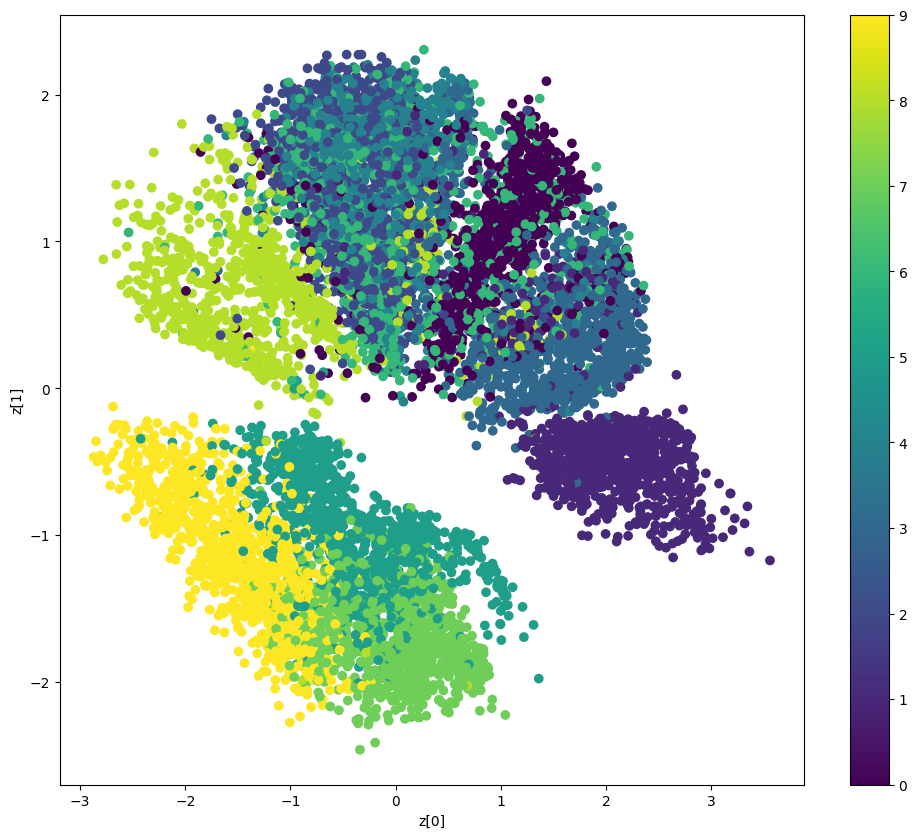

1/1 [==============================] - 0s 16ms/step


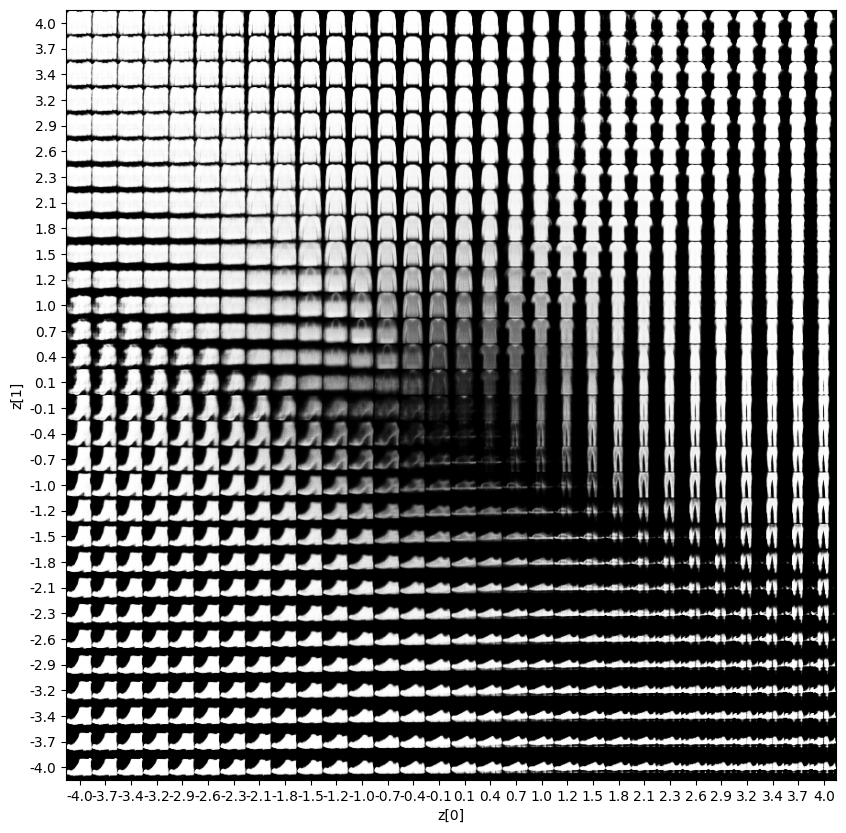

In [68]:
plot_results(encoder, decoder, x_test, y_test, batch_size=batch_size)